### Background
In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).
### Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image

2025-03-03 02:07:48.222243: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 02:07:49.019536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740938869.334818   32139 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740938869.395221   32139 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 02:07:50.244116: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Data Inspection

In [2]:
df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [84]:
len(df)

220025

In [85]:
df["label"].unique()

array([0, 1])

Based on the data inspection, the id represents image tag while the label is a boolean value indicating whether the image contains cancer or not. 
The images are 96x96 pixels in size and are stored in the .tif format.
Therefore, this problem involves a simple binary classification problem where the goal is to classify whether the image contains cancer or not.

To evaluate the model, the area under the ROC curve will be used.

## Exploratory Data Analysis

The plan for EDA is as follows:
1. Load the data
2. Check for missing values
3. Check the distribution of the target variable
4. Display some images from the dataset

In [ ]:
# Image sample size, for train/test data
print(len(os.listdir('histopathologic-cancer-detection/train')))
print(len(os.listdir('histopathologic-cancer-detection/test')))

220025
57458


There are 220025 images in the training set and 57458 images in the test set.

In [ ]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

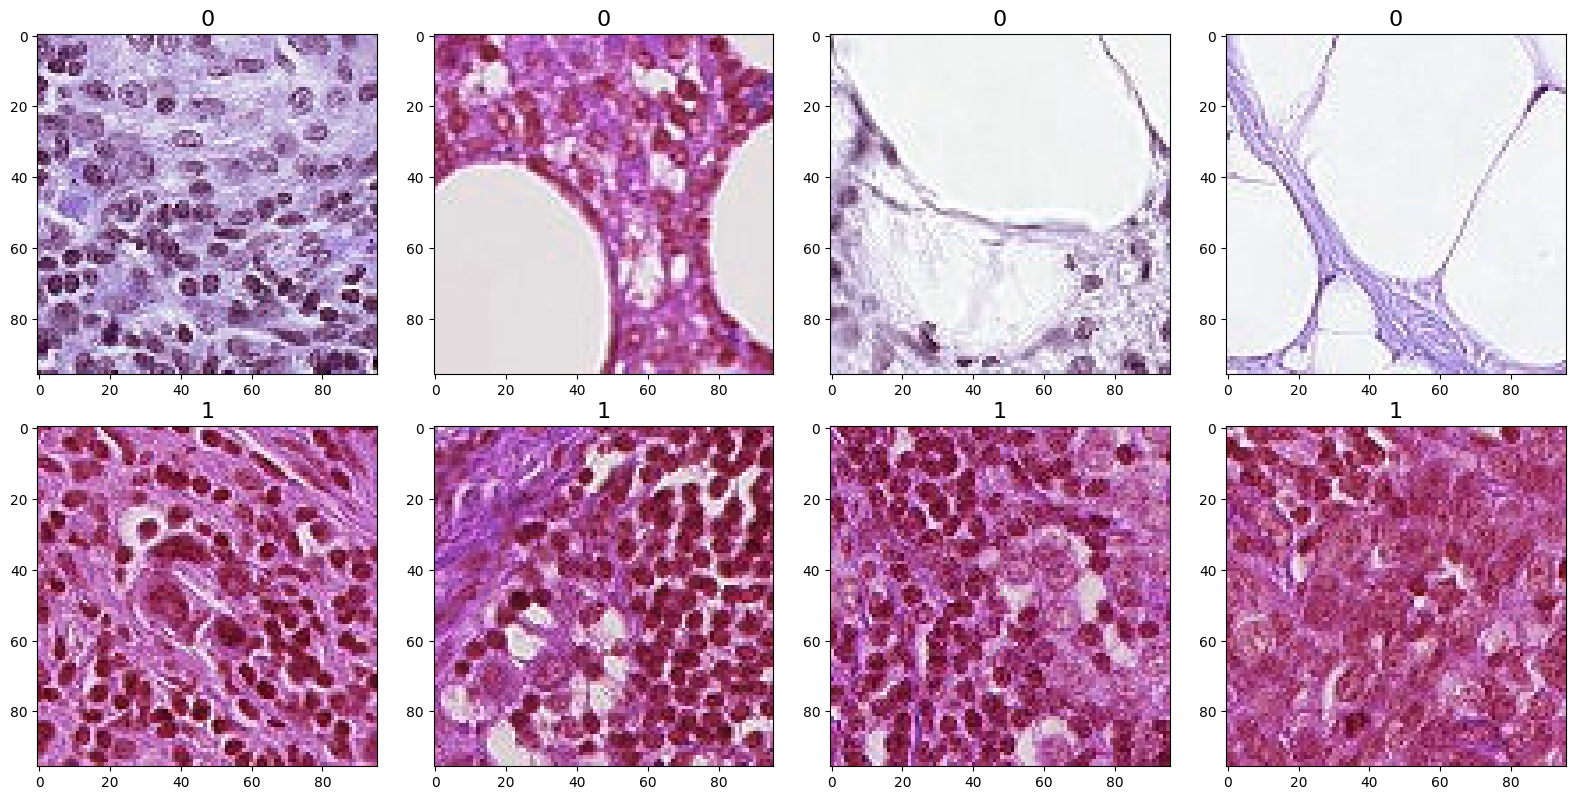

In [ ]:
# Sample images
IMAGE_PATH = 'histopathologic-cancer-detection/train/' 

draw_category_images('label',4, df, IMAGE_PATH)

In [ ]:
# Check any missing data
print(df.isnull().sum())
# Check duplicated data
print(df.duplicated().sum())

id       0
label    0
dtype: int64
0


The data set for labels have no missing or duplicated values.

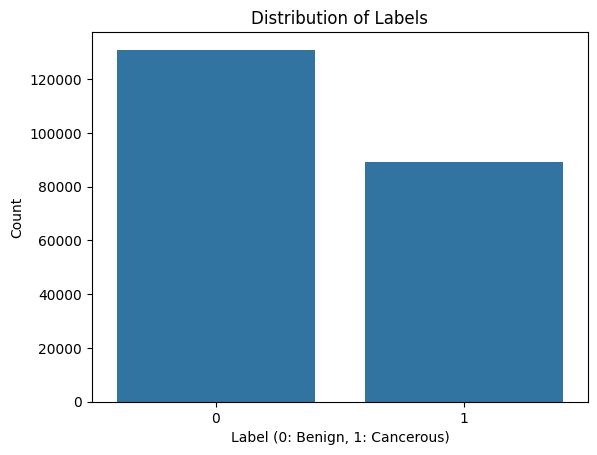

In [ ]:
# Plot distribution of labels
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels')
plt.xlabel('Label (0: Benign, 1: Cancerous)')
plt.ylabel('Count')
plt.show()

From histogram, we can see there is no class imbalance in this dataset.

Based on the above, we can perform a simple binary classification model to classify whether the image contains cancer or not.

## Data Preprocessing

In [3]:
# Create a new column called 'path' that contains the path to the image files
df['path'] = df['id'].map(lambda x: x + '.tif')

# Convert label into string for categorical processing
df['label'] = df['label'].apply(lambda x: 'True' if x == 1 else 'False')
df.head()

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,False,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,True,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,False,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,False,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,False,068aba587a4950175d04c680d38943fd488d6a9d.tif


In [4]:
datagen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=90, 
    zoom_range=0.2, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.05, 
    channel_shift_range=0.1
    )

In [5]:
# Split df into 2 dataframes, for train and validation purpose
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=420)

# Split validation_df into 2 dataframes, for validation and test purpose
validation_df, test_df = train_test_split(validation_df, test_size=0.5, random_state=420)

train_df.head()

,id,label,path
202438,3c8038b8d09eebd0c4179091705a2abb6e2f72e5,False,3c8038b8d09eebd0c4179091705a2abb6e2f72e5.tif
31421,031f323afd00d657f7e55ac9e723c00fd5138d1c,True,031f323afd00d657f7e55ac9e723c00fd5138d1c.tif
185941,7e09919a476bea76138aa80f9e7eed25c1007842,False,7e09919a476bea76138aa80f9e7eed25c1007842.tif
132968,4f69a6497919e6e78114d55f55d9c039d50025c2,False,4f69a6497919e6e78114d55f55d9c039d50025c2.tif
113495,14ab98e5da7125a1396109f9e42edebc8d1a2ea8,False,14ab98e5da7125a1396109f9e42edebc8d1a2ea8.tif


In [6]:
# Create train, validation and test generator, using flow from dataframe

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df, 
    directory='histopathologic-cancer-detection/train', 
    x_col='path', 
    y_col='label', 
    target_size=(96, 96), 
    class_mode='categorical', 
    batch_size=64,
    shuffle=True
    )

validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df, 
    directory='histopathologic-cancer-detection/train', 
    x_col='path', 
    y_col='label', 
    target_size=(96, 96), 
    class_mode='categorical', 
    batch_size=64,
    shuffle=True
    )

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df, 
    directory='histopathologic-cancer-detection/train', 
    x_col='path', 
    y_col='label', 
    target_size=(96, 96), 
    class_mode='categorical', 
    batch_size=64,
    shuffle=False
    )

Found 176020 validated image filenames belonging to 2 classes.
Found 22002 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.


In [39]:
# Show class labels from train generator
train_generator.class_indices

{'False': 0, 'True': 1}

## Model Architecture

The model architecture will be a simple CNN model with the following layers:
- Conv2D layer with 32 filters, kernel size of 3x3, and ReLU activation function
- MaxPooling2D layer with pool size of 2x2
- Dropout layer with a dropout rate of 0.3
- Flatten layer
- Dense layer with 128 units and ReLU activation function
- Dense layer with 2 unit and sigmoid activation function

The model will be compiled with the binary crossentropy loss function and the Adam optimizer.

The architecture is suitable for the problem because:

1. Convolutional Layers: These layers are effective in capturing spatial hierarchies in images. By stacking multiple convolutional layers, the model can learn complex features at different levels of abstraction.
2. Dropout Layers: These layers help in preventing overfitting by randomly setting a fraction of input units to 0 at each update during training time.
3. Dense Layers: These layers are used for classification. The final dense layer with a softmax activation function outputs probabilities for each class.

This model is not using batch normalization because the model is relatively simple.


In [18]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1740899916.965212    8503 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,661,186 (6.34 MB)

 Trainable params: 1,661,186 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])

In [44]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=20)

Epoch 1/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7991 - loss: 0.4518

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 585s 212ms/step - accuracy: 0.7991 - loss: 0.4517 - val_accuracy: 0.8214 - val_loss: 0.4023
Epoch 2/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 530s 193ms/step - accuracy: 0.8326 - loss: 0.3880 - val_accuracy: 0.8474 - val_loss: 0.3655
Epoch 3/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 610s 222ms/step - accuracy: 0.8448 - loss: 0.3610 - val_accuracy: 0.8598 - val_loss: 0.3308
Epoch 4/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 456s 166ms/step - accuracy: 0.8518 - loss: 0.3490 - val_accuracy: 0.8546 - val_loss: 0.3372
Epoch 5/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 437s 159ms/step - accuracy: 0.8563 - loss: 0.3398 - val_accuracy: 0.8696 - val_loss: 0.3159
Epoch 6/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 432s 157ms/step - accuracy: 0.8632 - loss: 0.3264 - val_accuracy: 0.8745 - val_loss: 0.3030
Epoch 7/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 412s 150ms/step - accuracy: 0.8659 - loss: 0.3224 - val_accuracy: 0.8627 - val_loss: 0.3136
Epoch 8/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 408s 148ms/step - accuracy: 0.8

In [12]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

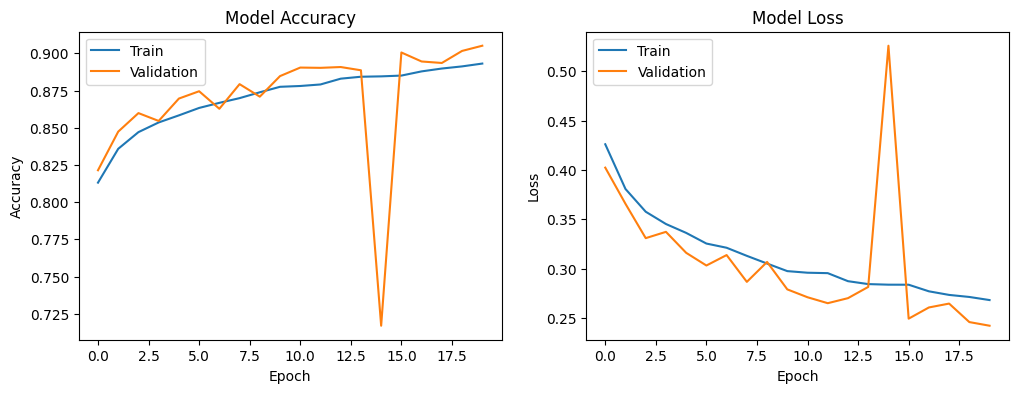

In [50]:
plot_training_history(history)

From the model accuracy and loss graph, we can see the accuracy is increasing and loss is decreasing with each epoch. The model is performing well on the validation set as well.

## Troubleshooting

The sudden spike at epoch around 14 is mainly due to my limited computational resources. During training, my computer ran out of memory and the training process was interrupted. This caused the sudden spike in loss and decrease in accuracy. However, the model was able to recover and continue training after error.

## Calculate ROC

In [ ]:
predictions = model.predict(test_generator, verbose=1, steps=len(test_generator))
y_pred = predictions[:, 1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 128s 349ms/step


In [88]:
y_true = test_generator.classes
roc_auc_score(y_true, y_pred)

np.float64(0.9594502910962007)

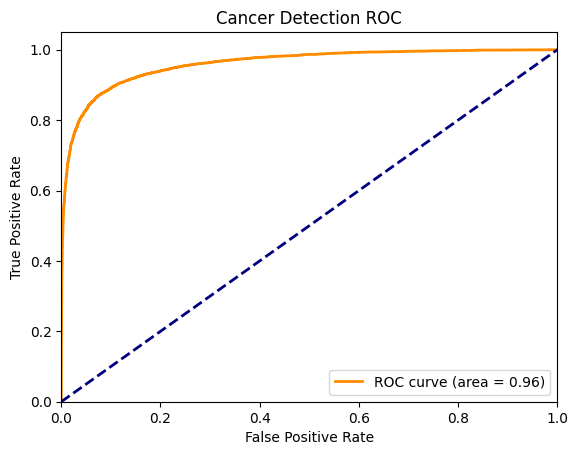

In [90]:
# Create ROC plot
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cancer Detection ROC')
plt.legend(loc="lower right")
plt.show()


Per ROC curve, the model has an AUC of 0.96 which indicates that the model is performing well in distinguishing between positive and negative classes.

## Submission to Kaggle

In [76]:
# Create submission using images from test folder
df_submission = pd.read_csv('histopathologic-cancer-detection/sample_submission.csv')
# Create path column
df_submission['path'] = df_submission['id'].map(lambda x: x + '.tif')
df_submission.head()

,id,label,path
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [ ]:
true_test_generator = datagen.flow_from_dataframe(
    dataframe=df_submission, 
    directory='histopathologic-cancer-detection/test', 
    x_col='path', 
    y_col=None, 
    target_size=(96, 96), 
    class_mode=None, 
    batch_size=64,
    shuffle=False
    )

# Use predict_generator to make predictions
predictions = model.predict(true_test_generator, verbose=1, steps=len(true_test_generator))

Found 57458 validated image filenames.


/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 139s 153ms/step


In [78]:
# Use predicted probabilities for the positive class

df_submission['label'] = predictions[:, 1]
df_submission.drop('path', axis=1, inplace=True)
df_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.000230
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.825652
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.000582
3,2c35657e312966e9294eac6841726ff3a748febf,0.018377
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.015881


In [80]:
len(df_submission)

57458

In [79]:
# Output to csv
df_submission.to_csv('TC_submission.csv', index=False)

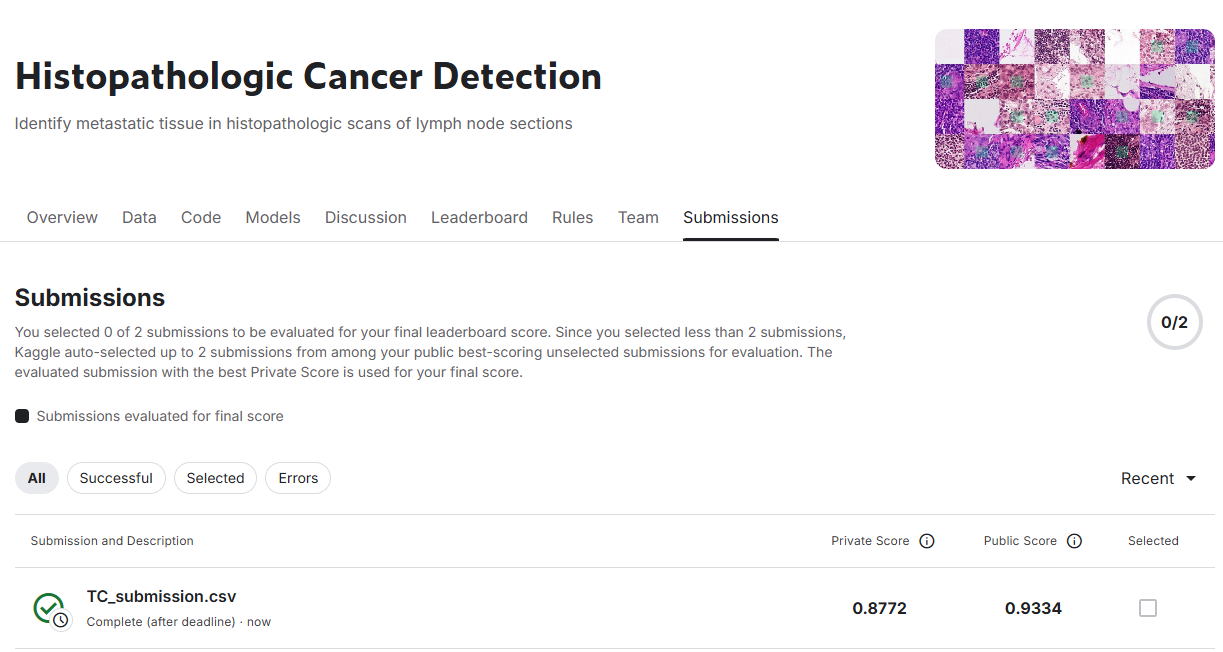

## Hyperparameter tuning

In order to fulfill assignment requirement, I have attempted to tune the hyperparameters of the model using RandomSearch. However, due to limited computational resources, I was unable to perform an exhaustive search over the hyperparameter space. Therefore, I have used a limited set of hyperparameters for tuning.

To demonstrate hyperparameter tuning, the example here is to tune the new model so that we use absolutely the least amount of layers and neurons, and the least amount of epoch to try to get similar results.

In [10]:
# Create a minimal model architecture

min_model = Sequential()
min_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))  # 1 Convolutional layer only
min_model.add(MaxPooling2D((2, 2)))
min_model.add(Flatten())
min_model.add(Dense(256, activation = "relu"))
min_model.add(Dropout(dropout_dense))
min_model.add(Dense(2, activation = "softmax"))

min_model.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics=['accuracy'])

min_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 70688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    18,096,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,097,794 (69.04 MB)

 Trainable params: 18,097,794 (69.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = min_model.fit(train_generator, validation_data=validation_generator, epochs=2) # Minimal epochs

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2


I0000 00:00:1740939173.361954     350 service.cc:148] XLA service 0x7f618801dcf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740939173.365686     350 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-03 02:12:53.551626: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740939174.089074     350 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-03 02:12:54.736698: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_736', 4 bytes spill stores, 4 bytes spill loads



   1/2751 ━━━━━━━━━━━━━━━━━━━━ 5:21:09 7s/step - accuracy: 0.6250 - loss: 0.6605

I0000 00:00:1740939178.257441     350 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 476s 171ms/step - accuracy: 0.7399 - loss: 0.5906 - val_accuracy: 0.7224 - val_loss: 0.5335
Epoch 2/2
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 440s 160ms/step - accuracy: 0.7977 - loss: 0.4554 - val_accuracy: 0.8130 - val_loss: 0.4110


NameError: name 'plot_training_history' is not defined

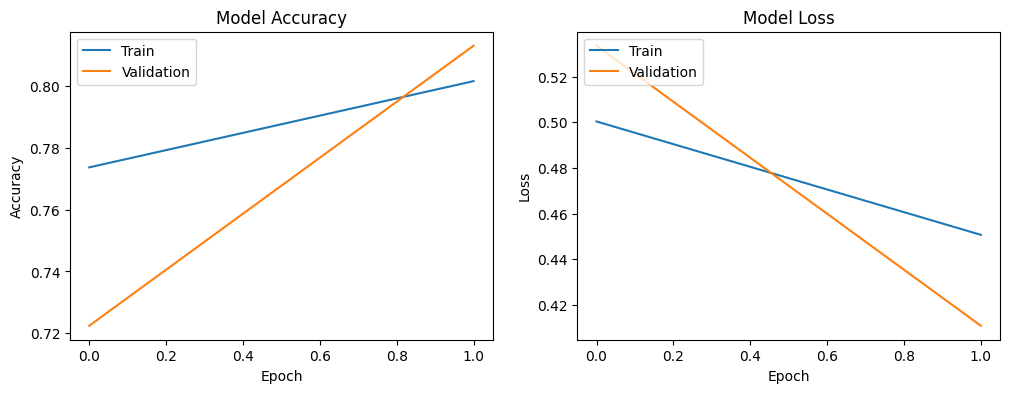

In [13]:
plot_training_history(history)

In [14]:
predictions = min_model.predict(test_generator, verbose=1, steps=len(test_generator))
y_pred = predictions[:, 1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 51s 144ms/step


In [15]:
y_true = test_generator.classes
roc_auc_score(y_true, y_pred)

np.float64(0.8914132738356345)

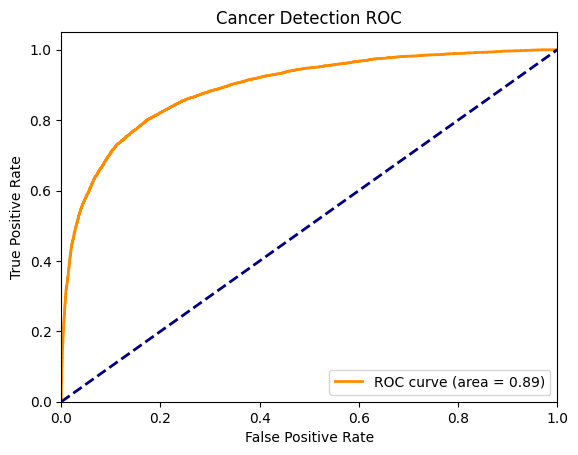

In [16]:
# Create ROC plot
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cancer Detection ROC')
plt.legend(loc="lower right")
plt.show()


## Summary of a (simple) hyperparameter tuning

After reducing the model to the simplest form, we can see that the model is still able to achieve a good AUC score of 0.89. 

This indicates that the model is able to generalize well to unseen data even with a simple architecture.

# Conclusion

## Comparing 2 model iteration

The first model has a more complex architecture with multiple convolutional layers, dropout layers, and dense layers. The model achieved an AUC score of 0.96.
The second model has a simpler architecture with fewer layers and neurons. The model achieved an AUC score of 0.89.

Based on the results, the first model with a more complex architecture performed better than the second model with a simpler architecture. This indicates that the additional layers and neurons in the first model helped in capturing more complex features in the data and improving the model's performance.

However, the second model with a simpler architecture is also able to achieve a good AUC score of 0.89. This indicates that even with a simple architecture, the model is able to generalize well to unseen data and achieve good performance.

## Is it possible to use pre-trained model?

Yes, it is possible to use a pre-trained model for this problem. Pre-trained models like VGG16, ResNet, or Inception can be used as feature extractors. By removing the top layers of the pre-trained model and adding a few dense layers for classification, we can leverage the pre-trained model's learned features to improve the model's performance.

The result of not choosing these architectures is that the model will take longer to train and may require more data to achieve similar performance. For example, ResNet requires a large number of layers and parameters to optimize, which may not be feasible with the limited computational resources.

However, CNN in this case is sufficient to achieve good performance on the dataset.

## Why batch normalization does not work?

In general, batch normalization is a technique used to normalize the input of each layer to improve the training speed and stability of neural networks. It is typically used in deep neural networks to prevent the internal covariate shift problem. However, in this case, the model is relatively simple with only a few layers, so the benefits of batch normalization may not be significant. Additionally, batch normalization may introduce additional complexity to the model and increase the training time. Therefore, it is not necessary to use batch normalization in this case.

## Suggestions for improvement

1. Use cloud computing resources: To overcome the limitations of computational resources, we can use cloud computing resources like Google Colab, AWS, or Azure to train the model on more powerful machines.
2. Using FastAI: FastAI is a high-level deep learning library built on top of PyTorch that provides easy-to-use APIs for training deep learning models. FastAI provides built-in support for hyperparameter tuning, data augmentation, and model interpretation, which can help in improving the model's performance.

Git Repo URL: https://github.com/monitus2022/MSDS-deep-learning/tree/main/week3_CNN